# TP3 - VPC

## Consigna

![alt text for screen readers](consigna.png "")

## Solucion

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

### Punto 1

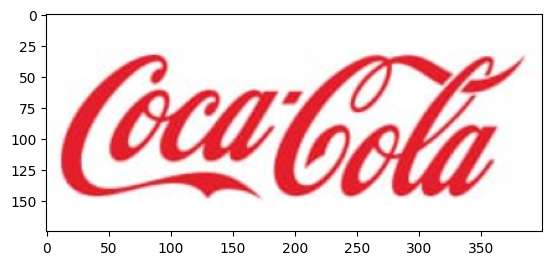

In [3]:
template_read = cv2.imread('../../Material_TPs/TP3/template/pattern.png')
template = cv2.cvtColor(template_read, cv2.COLOR_BGR2RGB)
plt.imshow(template)

In [4]:
def preprocess(image, th1 = 100, th2 = 200, trim = False, smooth = False, kernel_size = (5, 5)):
    if smooth:
        image = cv2.GaussianBlur(image, kernel_size, 11)
    edges = cv2.Canny(image,th1,th2)
    if trim:
        rows_to_remove = np.all(edges == 0, axis=1)
        clean_rows = edges[~rows_to_remove]
        columns_to_remove = np.all(clean_rows == 0, axis=0)
        clean_rows_and_columns = clean_rows[:, ~columns_to_remove]
        edges = clean_rows_and_columns
    return edges

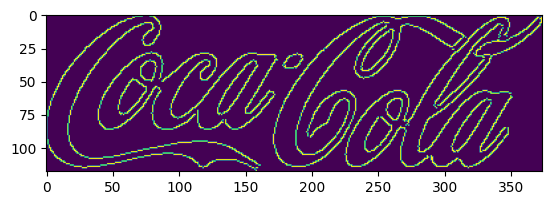

In [5]:
template_resized = preprocess(template, trim=True, smooth=True)
plt.imshow(template_resized)
plt.show()

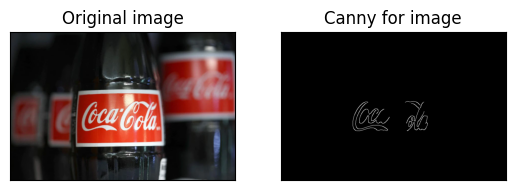

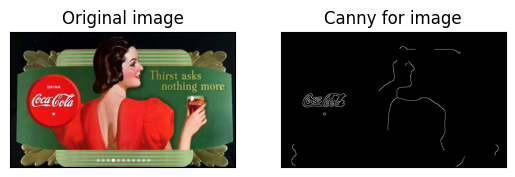

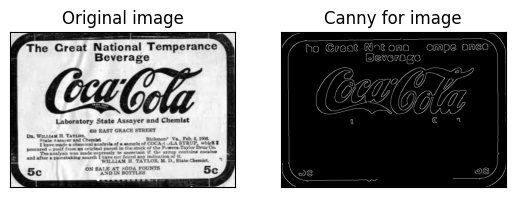

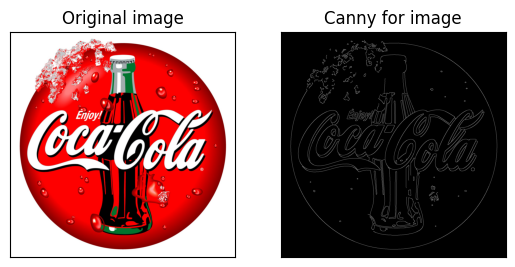

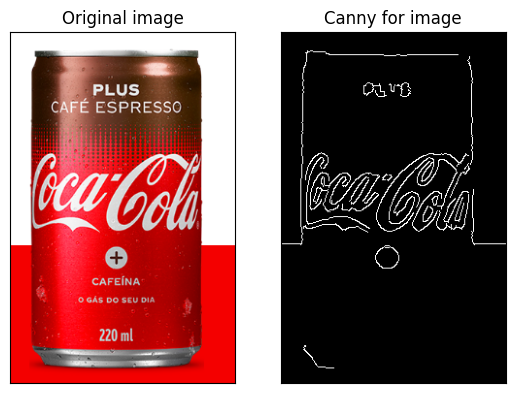

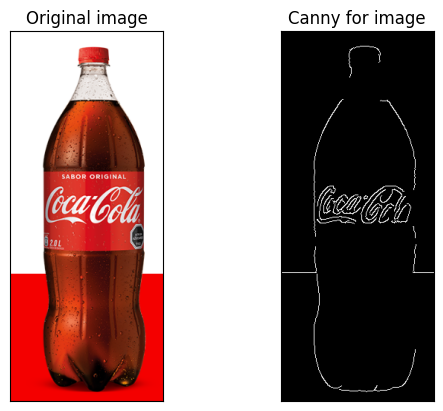

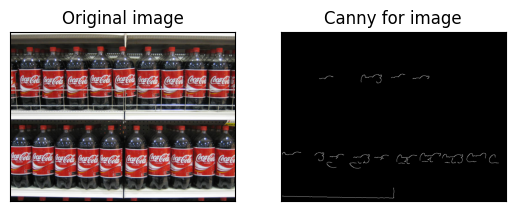

In [6]:
directory = '../../Material_TPs/TP3/images'
images = []
images_canny = []

for filename in os.listdir(directory):
    img_path = os.path.join(directory, filename)
    im_read = cv2.imread(img_path)
    im = cv2.cvtColor(im_read, cv2.COLOR_BGR2RGB)
    images.append(im)

for image in images:    
    canny = preprocess(image, 200, 450, smooth=True)
    images_canny.append(canny)

    plt.subplot(121),plt.imshow(image,cmap = 'gray')
    plt.title('Original image'), plt.xticks([]), plt.yticks([])
    
    plt.subplot(122),plt.imshow(canny, cmap = 'gray')
    plt.title('Canny for image'), plt.xticks([]), plt.yticks([])

    plt.show()

In [7]:
methods = [
    # ("TM_CCOEFF", cv2.TM_CCOEFF),
    # ("TM_CCORR", cv2.TM_CCORR),
    # ("TM_SQDIFF", cv2.TM_SQDIFF),
    ("TM_CCOEFF_NORMED", cv2.TM_CCOEFF_NORMED),
    ("TM_CCORR_NORMED", cv2.TM_CCORR_NORMED),
    # ("TM_SQDIFF_NORMED", cv2.TM_SQDIFF_NORMED)
]

scale_range = np.arange(5, 400, 1)/100

template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

In [8]:
def match_template_wrapper(img, template, method):

    h, w = template.shape[0], template.shape[1]

    if (img.shape[0] >= template.shape[0]) and (img.shape[1] >= template.shape[1]):

        matching_result = cv2.matchTemplate(img, template, method[1])

        _, max_val, min_loc, max_loc = cv2.minMaxLoc(matching_result)

        if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
            top_left = min_loc
        else:
            top_left = max_loc

        bottom_right = (top_left[0] + w, top_left[1] + h)
        return matching_result, max_val, top_left, bottom_right

        # return matching_result, max_val, tuple(int(element * scale) for element in top_left), tuple(int(element * scale) for element in bottom_right)

In [9]:
from skimage.metrics import structural_similarity
import imagehash
from PIL import Image

def compare_images_sift(img1, img2):
    sift = cv2.SIFT_create()

    _, descriptors1 = sift.detectAndCompute(img1, None)
    _, descriptors2 = sift.detectAndCompute(img2, None)

    matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

    matches = matcher.match(descriptors1, descriptors2)

    matches = sorted(matches, key=lambda x: x.distance)

    similarity_score = len(matches)

    return similarity_score

def mse(img1, img2):
   h, w = img1.shape[0], img1.shape[1]
   diff = cv2.subtract(img1, img2)
   err = np.sum(diff**2)
   mse = err/(float(h*w))
   return 1/mse

def hash_compare(img1, img2):
    hash1 = imagehash.average_hash(Image.fromarray(img1))
    hash2 = imagehash.average_hash(Image.fromarray(img2))
    hamming_distance = hash1 - hash2
    similarity_score = 1.0 - (hamming_distance / len(hash1.hash) ** 2)
    return similarity_score

In [10]:
def generate_results(image, template, methods, scale = 1):

    possible_results = []

    for method in methods:
        for scale in scale_range:
            template_resized = preprocess(template, smooth=True, trim=True)                
            template_resized = cv2.resize(template_resized, None, fx = scale, fy = scale)

            image_canny = preprocess(image, 350, 450, smooth=True)

            possible_result = match_template_wrapper(image_canny, template_resized, method)

            if possible_result is not None:

                matching_result, _, top_left, bottom_right = possible_result

                x1, y1 = top_left
                x2, y2 = bottom_right

                cropped_image = image[y1:y2, x1:x2]

                cropped_image = preprocess(cropped_image)

                score = hash_compare(cropped_image, template_resized)

                possible_results.append((matching_result, score, top_left, bottom_right))

    possible_results.sort(key=lambda x: x[1], reverse=True)

    return possible_results[0]


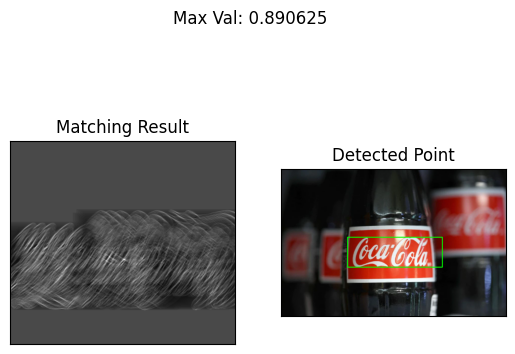

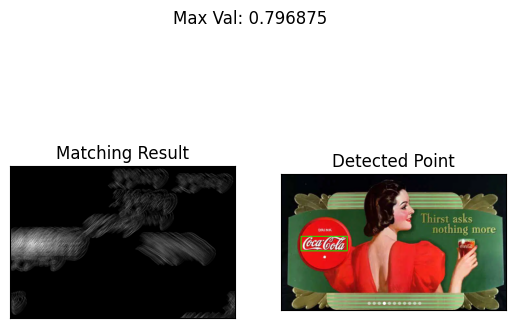

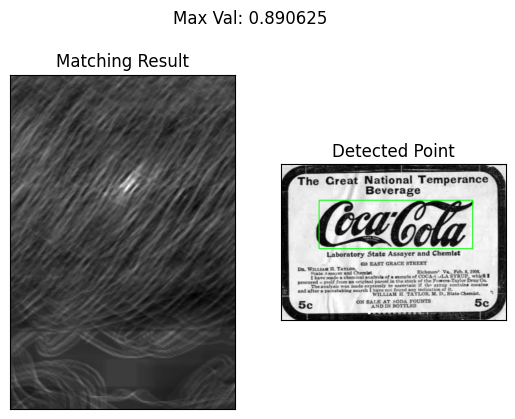

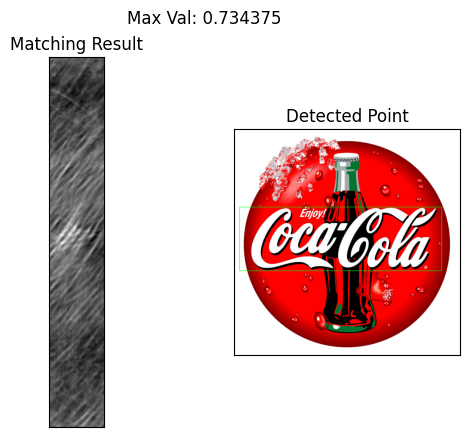

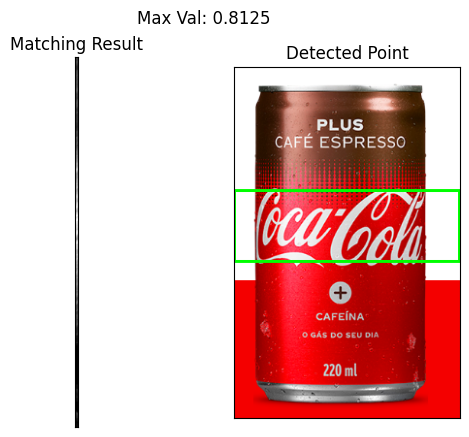

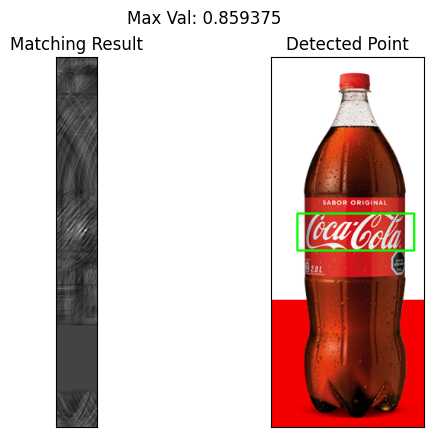

In [11]:
for image in images[0:6]:

    matching_result, score, top_left, bottom_right = generate_results(image, template_gray, methods)

    output_image = image.copy()

    cv2.rectangle(output_image, top_left, bottom_right, (0, 255, 0), 2)

    plt.subplot(121),plt.imshow(matching_result,cmap = 'gray')
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])

    plt.subplot(122),plt.imshow(output_image)
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])

    plt.suptitle(f"Max Val: {score}")

    plt.show()

### Punto 2 y 3

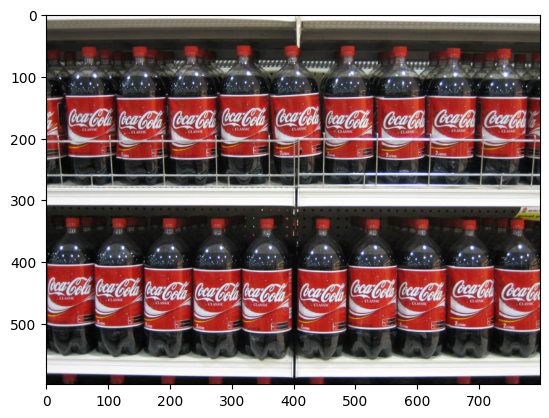

In [12]:
multiple = cv2.imread('../../Material_TPs/TP3/images/coca_multi.png')
multiple = cv2.cvtColor(multiple, cv2.COLOR_BGR2RGB)
plt.imshow(multiple)

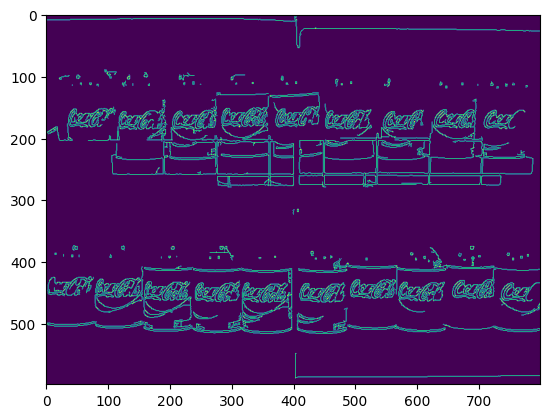

In [18]:
image_edges = preprocess(multiple, 900, 100)
plt.imshow(image_edges)

In [14]:
def do_overlap(rect1, rect2):
    rect1_top_left, rect1_bottom_right = rect1
    rect2_top_left, rect2_bottom_right = rect2

    if (rect1_top_left[0] <= rect2_bottom_right[0] and
        rect1_bottom_right[0] >= rect2_top_left[0] and
        rect1_top_left[1] <= rect2_bottom_right[1] and
        rect1_bottom_right[1] >= rect2_top_left[1]):
        return True
    else:
        return False

def clean_overlaps(rectangles):
    non_overlapping = []
    for rect1 in rectangles:
        for rect2 in non_overlapping:
            if do_overlap(rect1, rect2):
                break
        else:  
            non_overlapping.append(rect1)
    return non_overlapping

def multiple_detections(image, template, scale = 1, method = cv2.TM_CCORR_NORMED, thresh = 0.8):

    output_image = image.copy()

    resized_template = cv2.resize(template, None, fx=scale, fy=scale)
    processed_template = preprocess(resized_template, trim=False, smooth=True)

    template_height, template_width = processed_template.shape[:2]

    image_edges = preprocess(image, 900, 100)

    res = cv2.matchTemplate(image_edges, processed_template, method)

    loc = np.where(res >= thresh)

    possible_matches = []

    for pt in zip(*loc[::-1]):
        top_left = (int(pt[0]), int(pt[1]))
        bottom_right = (top_left[0] + template_width, top_left[1] + template_height)
        possible_matches.append((top_left, bottom_right))
        
    possible_matches = clean_overlaps(possible_matches)
    
    for top_left, bottom_right in possible_matches:
        cv2.rectangle(output_image, top_left, bottom_right, (0, 255, 0), 2)
            
    return output_image, possible_matches

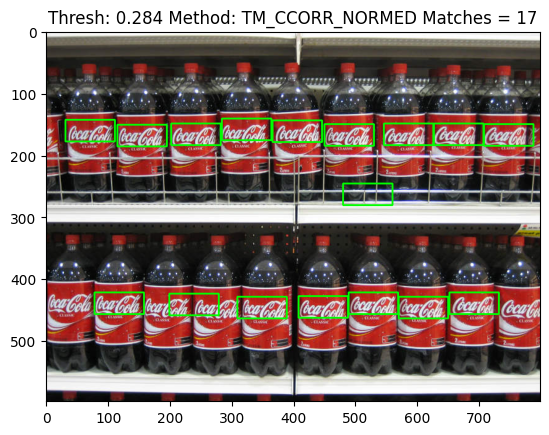

In [16]:
scale = 0.20
# for thresh in np.arange(280, 290, 1)/1000:
#     for method in [("TM_CCOEFF_NORMED", cv2.TM_CCOEFF_NORMED),("TM_CCORR_NORMED", cv2.TM_CCORR_NORMED)]:
thresh = 0.284
method = ("TM_CCORR_NORMED", cv2.TM_CCORR_NORMED)
output, matches = multiple_detections(multiple, template, scale=scale, thresh = thresh, method=method[1])
plt.imshow(output)
plt.title(f"Thresh: {thresh} Method: {method[0]} Matches = {len(matches)}")
plt.show()